In [82]:
initial_path = 'peptide-QML'
# initial_path = '..'

In [83]:
import sys
sys.path.append(initial_path)

%load_ext autoreload
%autoreload 2
from my_code import helper_classes as c
from my_code import pytorch_model as m
from my_code import quantum_nodes as q

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
# name of the notebook
name_notebook = "sweep_12h_er_Aqm"

In [85]:
# sweep = c.Sweep(
#     name_notebook, 
#     initial_path=initial_path,
#     description="(12aa, 6q) Try to find best number of q. layers (embedding and block) and type of Anzatz.",
#     repetitions=list(range(1, 4)),
#     embedding_n_layers=[1,3,5],
#     block_n_layers=[1,3,5,7,10,15],
#     ansatz=[q.parts.Ansatz_full_conn, q.parts.Ansatz_11],
# )

In [86]:
# sweep.save()

In [87]:
sweep = c.Sweep.load(file_name=name_notebook+"-3", day='0926', initial_path=initial_path)



 --- SWEEP POINT 1/108: (1, 1, 1, <class 'my_code.quantum_nodes.parts.Ansatz_full_conn'>) ---
 --- parameters sweeping: ['repetitions', 'embedding_n_layers', 'block_n_layers', 'ansatz'] 



Epoch [0/2], Loss epoch: 0.0485, Loss validation: 0.0491
	 Validation string, 	 i: 1404; 	 prediction: -0.3745, 	 target: -0.2942, 	 loss: 0.0064
	 Validation string, 	 i: 2556; 	 prediction: -0.4690, 	 target: -0.5142, 	 loss: 0.0020
	 Validation string, 	 i: 4392; 	 prediction: -0.3408, 	 target: -0.4329, 	 loss: 0.0085
Epoch [1/2], Loss epoch: 0.0090, Loss validation: 0.0085, Time remaining: ~0.0h 8.0m 26s
	 Validation string, 	 i: 56; 	 prediction: -0.2739, 	 target: -0.4717, 	 loss: 0.0391
	 Validation string, 	 i: 3969; 	 prediction: -0.1389, 	 target: -0.0829, 	 loss: 0.0031
	 Validation string, 	 i: 3670; 	 prediction: -0.4301, 	 target: -0.4667, 	 loss: 0.0013
Epoch [2/2], Loss epoch: 0.0085, Loss validation: 0.0083, Time remaining: ~0.0h 0.0m 0s


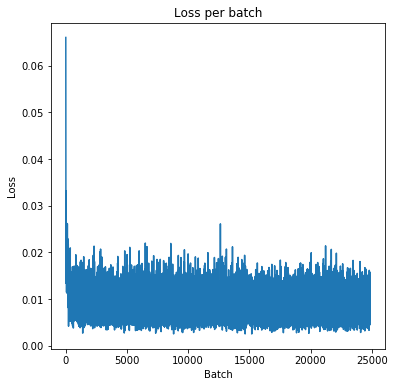

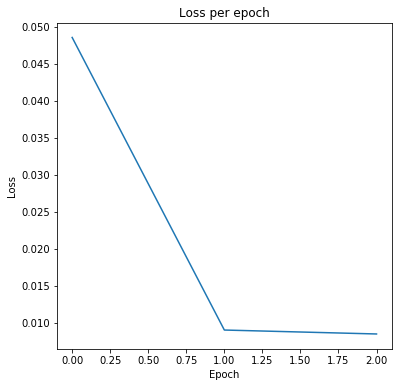

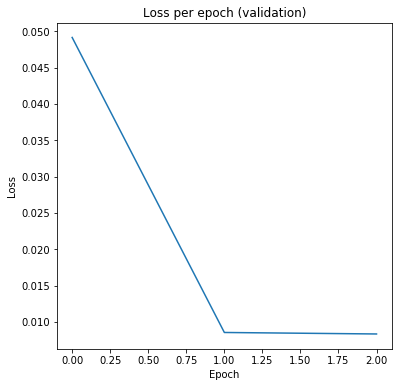

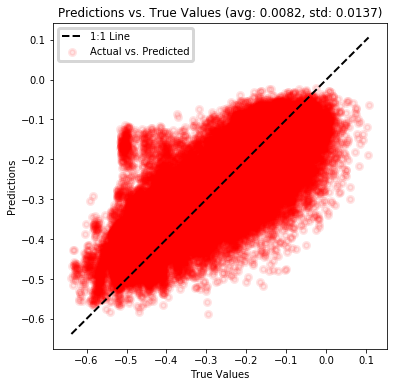

Mean loss: 0.008214617337872996, std loss: 0.013725527860620812


 --- SWEEP POINT 2/108: (1, 1, 1, <class 'my_code.quantum_nodes.parts.Ansatz_11'>) ---
 --- time reamining: 1564:02:57.58 

Epoch [0/2], Loss epoch: 0.1802, Loss validation: 0.1775
	 Validation string, 	 i: 1240; 	 prediction: -0.5586, 	 target: -0.5172, 	 loss: 0.0017
	 Validation string, 	 i: 2317; 	 prediction: -0.1349, 	 target: -0.3110, 	 loss: 0.0310
	 Validation string, 	 i: 3247; 	 prediction: -0.4073, 	 target: -0.4003, 	 loss: 0.0000
Epoch [1/2], Loss epoch: 0.0089, Loss validation: 0.0081, Time remaining: ~0.0h 10.0m 17s
	 Validation string, 	 i: 2089; 	 prediction: -0.3185, 	 target: -0.2471, 	 loss: 0.0051
	 Validation string, 	 i: 2131; 	 prediction: -0.3028, 	 target: -0.3446, 	 loss: 0.0017
	 Validation string, 	 i: 546; 	 prediction: -0.1950, 	 target: -0.2691, 	 loss: 0.0055
Epoch [2/2], Loss epoch: 0.0080, Loss validation: 0.0085, Time remaining: ~0.0h 0.0m 0s


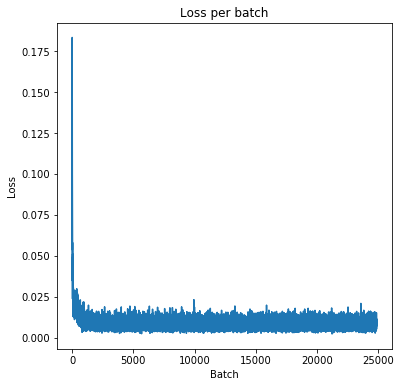

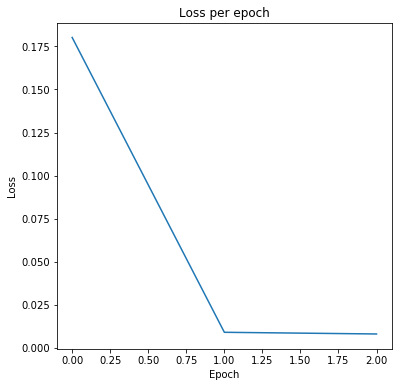

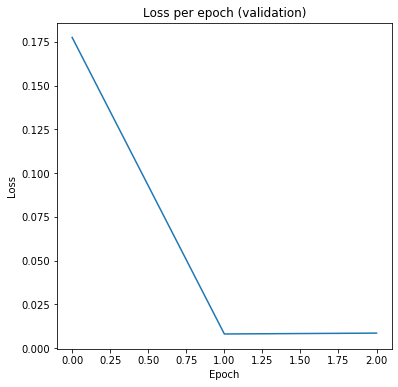

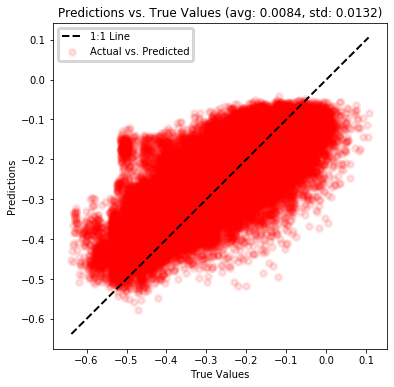

Mean loss: 0.0084472566556518, std loss: 0.013239869202371543


 --- SWEEP POINT 3/108: (1, 1, 3, <class 'my_code.quantum_nodes.parts.Ansatz_full_conn'>) ---
 --- time reamining: 807:51:52.04 

Epoch [0/2], Loss epoch: 0.3170, Loss validation: 0.3181
	 Validation string, 	 i: 3428; 	 prediction: -0.1105, 	 target: -0.2072, 	 loss: 0.0093
	 Validation string, 	 i: 3742; 	 prediction: -0.2174, 	 target: -0.2405, 	 loss: 0.0005
	 Validation string, 	 i: 1113; 	 prediction: -0.1722, 	 target: -0.1013, 	 loss: 0.0050
Epoch [1/2], Loss epoch: 0.0115, Loss validation: 0.0099, Time remaining: ~0.0h 12.0m 27s
	 Validation string, 	 i: 2377; 	 prediction: -0.1870, 	 target: -0.1418, 	 loss: 0.0020
	 Validation string, 	 i: 1838; 	 prediction: -0.3772, 	 target: -0.4884, 	 loss: 0.0124
	 Validation string, 	 i: 827; 	 prediction: -0.3771, 	 target: -0.3448, 	 loss: 0.0010
Epoch [2/2], Loss epoch: 0.0101, Loss validation: 0.0103, Time remaining: ~0.0h 0.0m 0s


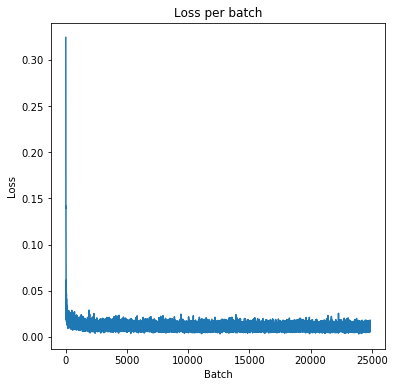

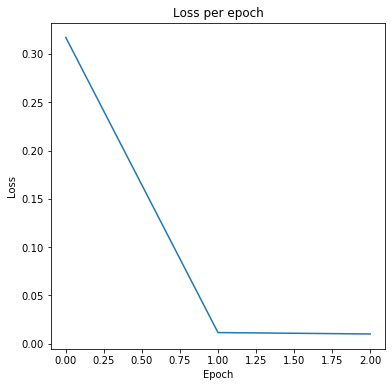

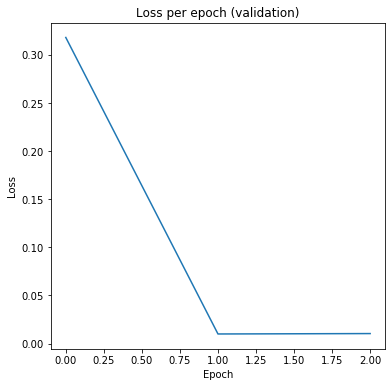

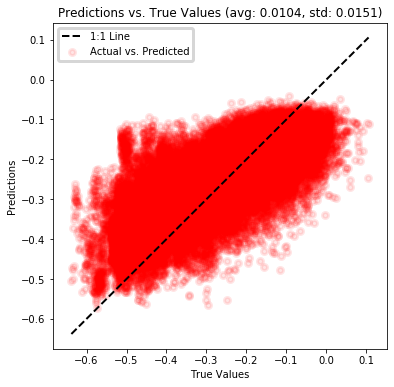

Mean loss: 0.010356960758535866, std loss: 0.015098308887856893


 --- SWEEP POINT 4/108: (1, 1, 3, <class 'my_code.quantum_nodes.parts.Ansatz_11'>) ---
 --- time reamining: 559:11:30.62 

Epoch [0/2], Loss epoch: 0.1106, Loss validation: 0.1121
	 Validation string, 	 i: 755; 	 prediction: -0.2009, 	 target: -0.1748, 	 loss: 0.0007
	 Validation string, 	 i: 1931; 	 prediction: -0.3830, 	 target: -0.4272, 	 loss: 0.0019
	 Validation string, 	 i: 1315; 	 prediction: -0.3971, 	 target: -0.2373, 	 loss: 0.0256
Epoch [1/2], Loss epoch: 0.0082, Loss validation: 0.0078, Time remaining: ~0.0h 17.0m 3s


In [88]:
for sweep_point in sweep.points_left:

    # print the point of the sweep
    sweep.print_sweep_status(sweep_point['idx'])

    # -- QUANTUM BLOCK -- #
    n_qubits = 6
    quantum_layer = q.circuit(
        n_qubits = n_qubits, 
        device = "default.qubit.torch",
        device_options = {'shots': None},
        embedding = q.parts.AngleEmbedding,
        embedding_ansatz = sweep_point['ansatz'],
        block_ansatz = sweep_point['ansatz'],
        final_ansatz = sweep_point['ansatz'], 
        measurement = q.parts.Measurement('Z', 'all'),
        embedding_n_layers = sweep_point['embedding_n_layers'],
        different_inputs_per_layer = True,
        block_n_layers = sweep_point['block_n_layers'],
        # wrapper_qlayer = pw.QLayerEmpty,
    )

    # -- MODEL -- #                    
    class Model(m.Model):
        def __init__(self):
            super(Model, self).__init__()
            self.fc1 = m.nn.Embedding(num_embeddings=19, embedding_dim=1)
            self.fc2 = m.Reshape()
            # self.fc3 = XXXXXXXX
            self.fc4 = quantum_layer()            
            self.fc5 = m.nn.Linear(n_qubits, 1)

        def fc3(self, x):
            return m.torch.cat(tuple(x for _ in range(sweep_point['embedding_n_layers']//2+1)), dim=x.dim()-1)

        def forward(self, x):
            for i in [1,2,3,4,5]:
                x = getattr(self, 'fc{}'.format(i))(x)
            return x

    model = Model()

    # set quantum layer
    model.set_quantum_layer(quantum_layer)

    # set the name and path of the model
    model.set_name_and_path(name_notebook, initial_path)

    #set sweep point
    model.set_sweep_point(
        sweep_uuid = sweep.uuid,
        sweep_point = sweep_point,
        day=sweep.day
    )

    # -- TRAIN -- #
    model.optimize_params(
        #save info
        save_model_info = True,
        description = 'sweep with 12aa and 6q -> Try to find best number of q. layers (embedding and block) and type of Anzatz.',    
        #data
        data=c.Data.load(initial_path=initial_path, file_name='PET_SCORES_12_Numbers_int'),
        # train options
        optimizer = m.optim.Adam,
        optimizer_options = {'lr': 0.01},
        num_epochs = 2,                
        batch_size = 32,
        # early stopping options
        stop_training_options = {
            'lookback_epochs': 5, 
            'threshold_slope': 0.001,
            'threshold_std_dev': 0.2
        },
        # metadata
        metadata = {}
    )

    # -- VALIDATION and PLOTS -- #
    model.plot_losses(fig_size=(6,6))
    model.validate(
        pct=1,
        add_to_results=True,
        plot=True,
        print_items=False
    )

    # -- SAVE RESULTS -- #
    model.save_results()

    # -- ADD DATA GENERATED TO SWEEP -- #
    sweep.add_data(
        idx=sweep_point['idx'],
        model_uuid=model.uuid,
        best_loss_train=model.results.loss_epoch.best,
        best_loss_test=model.results.loss_validation_epoch.best,
        loss_validation=model.mean_loss_validation,
        n_parameters=model.n_parameters,
        time_train=model.results.time_epoch.last,
    )
    sweep.save(csv=False) #TODO: save csv=False automatically when sweep is already saved ion csv

    